# **Curvetopia**

Objective: Our mission is to identify, regularize, and beautify curves in 2D Euclidean space. <br/>We'll start by focusing on closed curves and progressively work with more complex shapes. <br/>This project will also cover symmetry and curve completion techniques.<br/><br/>
Problem description: Ideally we want a end to end process <br/>where we take a PNG
(raster) image of a line art and output a set of curves, <br/>where the curves are defined as a connected sequence of cubic Bezier curves.

## **Required Python Libraries**

### **Installation**

In [137]:
!pip install svgwrite cairosvg scipy

### **Importing Modules into Python3**

In [138]:
import numpy as np
import matplotlib.pyplot as plt
import svgwrite
import cairosvg
from scipy.interpolate import splprep, splev
from scipy.spatial import ConvexHull
from PIL import Image
import io
import cv2
from google.colab.patches import cv2_imshow
import imutils
from scipy.spatial.transform import Rotation as R
from math import sqrt
from copy import copy

## **Global Variables**

In [139]:
# Colours list
colours = ['#FF5733', '#33FF57', '#3357FF', '#FF33A1', '#A133FF', '#33FFA1', '#FFBF00']

# Use case
use_case = "isolated"

# Input file path
input_csv_path = f"/content/{use_case}.csv"

# Output JPG file
output_jpg_path = f"/content/{use_case}_sol.jpg"

# Input image file path
input_img_path = f"/content/{use_case}_sol.jpg"

# Output SVG file
output_svg_path = f"/content/{use_case}.svg"

# Square root of 2 (for trigonometry)
two_root = sqrt(2)

## **Visualize Polylines**
Using code provided by Adobe Experts

### **Read CSV File**

In [140]:
def pretty_print_paths(paths_XYs):
    """
    Prints the content of the paths_XYs array in a human-readable format.

    :param paths_XYs: List of lists of NumPy arrays containing XY coordinates.
    """
    for i, path in enumerate(paths_XYs):
        print(f"Path {i + 1}:")

        for j, XY in enumerate(path):
            print(f"  Segment {j + 1}:")

            for point in XY:
                print(f"    ({point[0]}, {point[1]})")

        print("")  # Blank line between paths for clarity

def read_csv(csv_path):
    np_path_XYs = np.genfromtxt(csv_path, delimiter=',')
    path_XYs = []

    # Calculate the global maximum y value
    global_max_y = np.max(np_path_XYs[:, 2])

    for i in np.unique(np_path_XYs[:, 0]):
        npXYs = np_path_XYs[np_path_XYs[:, 0] == i][:, 1:]
        XYs = []

        for j in np.unique(npXYs[:, 0]):
            XY = npXYs[npXYs[:, 0] == j][:, 1:]
            # Invert the y-coordinate relative to the global maximum y
            XY[:, 1] = global_max_y - XY[:, 1]
            XYs.append(XY)

        path_XYs.append(XYs)

    pretty_print_paths(path_XYs)

    return path_XYs

# Function call
path_XYs = read_csv(input_csv_path)

Path 1:
  Segment 1:
    (109.14299774169922, 136.69700622558594)
    (110.15747833251953, 136.7812271118164)
    (111.17194366455078, 136.8730239868164)
    (112.18638610839844, 136.97178649902344)
    (113.20079040527344, 137.07689666748047)
    (114.21517181396484, 137.187744140625)
    (115.22950744628906, 137.30371856689453)
    (116.2437973022461, 137.4242172241211)
    (117.25804138183594, 137.54862213134766)
    (118.27222442626953, 137.67632293701172)
    (119.2863540649414, 137.80670928955078)
    (120.3004150390625, 137.93917846679688)
    (121.31440734863281, 138.07310485839844)
    (122.32831573486328, 138.2078857421875)
    (123.34214782714844, 138.34290313720703)
    (124.35589599609375, 138.47755432128906)
    (125.36954498291016, 138.6112289428711)
    (126.38310241699219, 138.74331665039062)
    (127.39655303955078, 138.87319946289062)
    (128.40989685058594, 139.0002670288086)
    (129.42312622070312, 139.12391662597656)
    (130.4362335205078, 139.2435302734375)
  

### **Plot Lines**

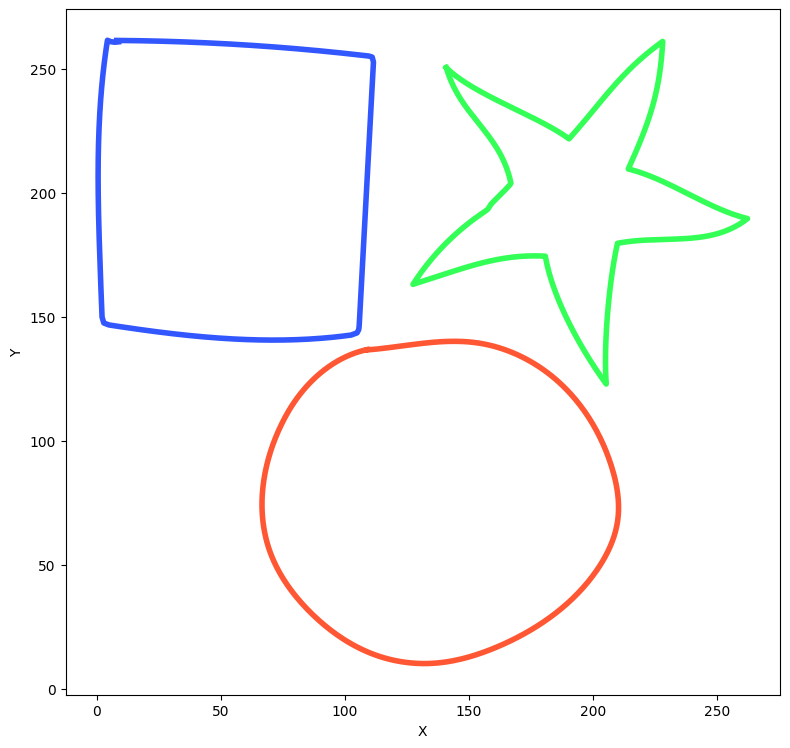

In [141]:
def plot(path_XYs):
    fig, ax = plt.subplots(tight_layout=True, figsize=(8, 8))

    for i, XYs in enumerate(path_XYs):
        c = colours[i % len(colours)]

        for XY in XYs:
            ax.plot(XY[:, 0], XY[:, 1], c=c, linewidth=4)

    ax.set_aspect('equal')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.show()

# Function call
plot(path_XYs)

### **Evaluate Output as SVG**

In [142]:
def polylines2svg(paths_XYs, svg_path):
    W, H = 0, 0

    # Calculate the maximum width and height
    for path_XYs in paths_XYs:
        for XY in path_XYs:
            W, H = max(W, np.max(XY[:, 0])), max(H, np.max(XY[:, 1]))

    # Add padding
    padding = 0.1
    W, H = int(W + padding * W), int(H + padding * H)

    # Create a new SVG drawing
    dwg = svgwrite.Drawing(svg_path, profile='tiny', shape_rendering='crispEdges')
    group = dwg.g()

    # Add paths to the SVG
    for i, path in enumerate(paths_XYs):
        path_data = []
        c = colours[i % len(colours)]

        for XY in path:
            path_data.append(("M", (XY[0, 0], XY[0, 1])))

            for j in range(1, len(XY)):
                path_data.append(("L", (XY[j, 0], XY[j, 1])))

            if not np.allclose(XY[0], XY[-1]):
                path_data.append(("Z", None))

        group.add(
            dwg.path(
                d=path_data,
                fill=c,
                stroke='none',
                stroke_width=2
            )
        )

    dwg.add(group)
    dwg.save()

    # Convert SVG to PNG
    png_path = svg_path.replace('.svg', '.png')
    fact = max(1, 1024 // min(H, W))

    cairosvg.svg2png(
        url=svg_path,
        write_to=png_path,
        parent_width=W,
        parent_height=H,
        output_width=fact * W,
        output_height=fact * H,
        background_color='white'
    )

    return png_path

# Function call
polylines2svg(path_XYs, output_svg_path)

'/content/isolated.png'

## **Smoothening Irregular Curves Using Bézier Curves**

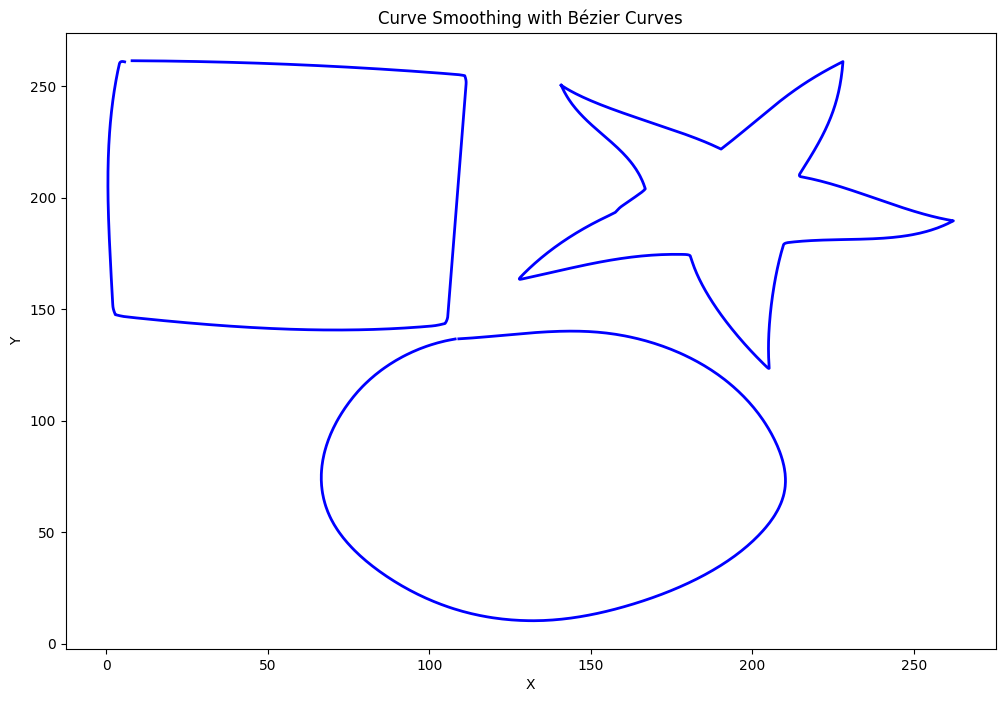

In [143]:
def bezier_curve(P0, P1, P2, P3, num_points=100):
    """
    Generate a cubic Bézier curve from control points.

    :param P0, P1, P2, P3: Control points for the Bézier curve.
    :param num_points: Number of points to generate along the curve.
    :return: Array of points along the Bézier curve.
    """
    t = np.linspace(0, 1, num_points).reshape(-1, 1)  # Reshape `t` to be a column vector
    curve = ((1-t)**3 * P0) + (3*(1-t)**2 * t * P1) + (3*(1-t) * t**2 * P2) + (t**3 * P3)
    return curve

def fit_bezier_segments(path_XYs, segment_length=4):
    """
    Fit cubic Bézier curves to segments of path_XYs.

    :param path_XYs: List of lists of NumPy arrays containing XY coordinates.
    :param segment_length: Number of points in each segment.
    :return: Smoothened curves as a list of lists of NumPy arrays.
    """
    smooth_paths = []

    for path in path_XYs:
        bezier_curves = []

        for XY in path:
            num_points = len(XY)

            # Loop through points in segments
            for i in range(0, num_points - segment_length + 1, segment_length - 1):
                # Select the points for the current segment
                segment = XY[i:i + segment_length]

                # Ensure there are enough points
                if len(segment) < segment_length:
                    break

                # Select control points
                P0, P1, P2, P3 = segment[0], segment[1], segment[2], segment[3]

                # Fit a Bézier curve to the segment
                curve = bezier_curve(P0, P1, P2, P3)
                bezier_curves.append(curve)

        # Concatenate the Bézier curve segments for the current path
        smooth_path = np.concatenate(bezier_curves, axis=0)
        smooth_paths.append(smooth_path)

    return smooth_paths

def plot_paths(smoothened_paths):
    """
    Plot the original and smoothened paths.

    :param original_paths: Original path_XYs containing the paths.
    :param smooth_paths: Smoothened paths as a list of lists of NumPy arrays.
    """
    plt.figure(figsize=(12, 8))

    for smooth in smoothened_paths:
        plt.plot(smooth[:, 0], smooth[:, 1], 'b-', linewidth=2)

    plt.title('Curve Smoothing with Bézier Curves')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.grid(False)
    plt.show()

# Smooth the curves
smoothened_paths = fit_bezier_segments(path_XYs, segment_length=4)

# Plot the results
plot_paths(smoothened_paths)

## **Curve Regularization**
Detecting shape types, then applying geometric adjustments to align and regularize them using OpenCV library

[137.16059292  76.38121344] 68.18909291217126


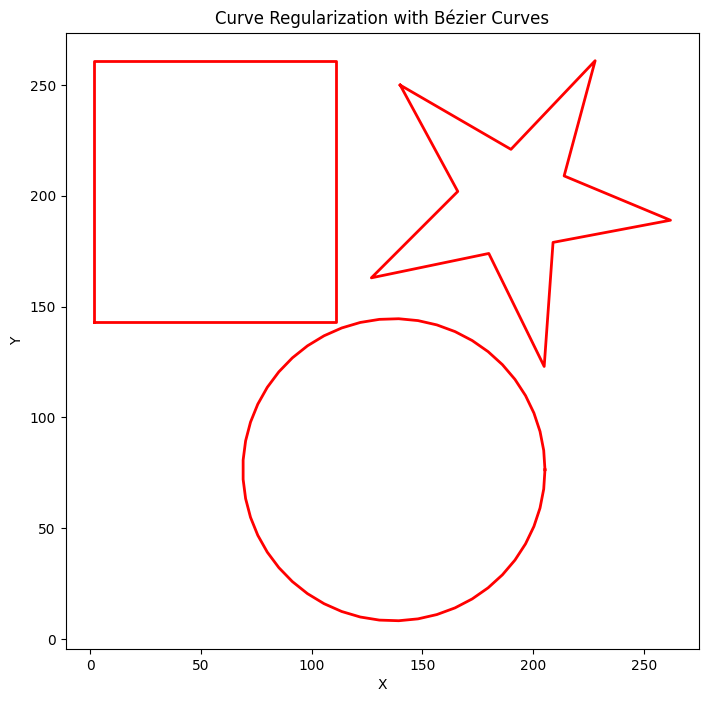

In [144]:
def approximate_polygon(points, epsilon=0.02):
    """Approximate a polygon from the given points."""
    # Compute the cumulative distance along the path
    cumulative_distances = np.cumsum(np.linalg.norm(np.diff(points, axis=0), axis=1))
    cumulative_distances = np.insert(cumulative_distances, 0, 0)

    # Approximate the polygon by selecting points at equal intervals
    num_points = len(points)
    interval = epsilon * cumulative_distances[-1]
    approx_polygon = [points[0]]

    for i in range(1, num_points - 1):
        if cumulative_distances[i] - cumulative_distances[0] >= interval:
            approx_polygon.append(points[i])
            cumulative_distances[0] = cumulative_distances[i]

    approx_polygon.append(points[-1])
    return np.array(approx_polygon)

def fit_circle(points):
    A = np.hstack((2*points, np.ones((len(points), 1))))
    b = np.sum(points**2, axis=1)
    c, _, _, _ = np.linalg.lstsq(A, b, rcond=None)
    center = c[:2]
    radius = np.sqrt(np.sum(center**2) + c[2])
    return center, radius

def is_deformed_square(corners, tolerance=20):
    """Check if the corners form a deformed square (all angles ~90 degrees)."""
    if len(corners) != 4:
        return False

    # Calculate angles between the sides
    vectors = np.diff(corners, axis=0)
    vectors = np.vstack((vectors, corners[0] - corners[-1]))  # Close the square
    angles = np.arccos(np.einsum('ij,ij->i', vectors, np.roll(vectors, 1, axis=0)) /
                       (np.linalg.norm(vectors, axis=1) * np.roll(np.linalg.norm(vectors, axis=1), 1)))

    # Convert radians to degrees and check if all angles are close to 90 degrees
    angles = np.degrees(angles)
    return np.all(np.abs(angles - 90) < tolerance)

def is_circle(smoothened_path, sampling_rate=0.1):
    # Downsample the points
    num_points = len(smoothened_path)
    sampled_points = smoothened_path[::max(1, int(1/sampling_rate))]

    # Estimate the circle using downsampled points
    center, radius = cv2.minEnclosingCircle(np.array(sampled_points, dtype=np.float32))
    distances = np.linalg.norm(np.array(sampled_points) - center, axis=1)

    # A threshold to determine if the points resemble a circle (based on deviation from the radius)
    threshold = 0.1 * radius
    return np.all(np.abs(distances - radius) < threshold), center, radius

def is_deformed_star(corners):
    if len(corners) == 10:  # Stars typically have 10 vertices (5 inner, 5 outer)
        return True
    return False

def regularize_star(corners):
    outer_points = corners[::2]
    inner_points = corners[1::2]

    regularized_star = []

    for i in range(len(outer_points)):
        regularized_star.append(outer_points[i])
        regularized_star.append(inner_points[i])

    regularized_star.append(outer_points[0])  # Close the loop

    return np.array(regularized_star)

def regularize_curves(smoothened_paths):
    regularized_paths = []

    for smoothened_path in smoothened_paths:
        # Detect the shape of the contour
        peri = cv2.arcLength(np.array([smoothened_path], dtype=np.int32), True)
        approx = cv2.approxPolyDP(np.array([smoothened_path], dtype=np.int32), 0.02 * peri, True)
        corners = approx.squeeze()

        # Check if polyline resembles square
        if is_deformed_square(corners):
            # Align corners to form a perfect square
            min_x, min_y = np.min(corners, axis=0)
            max_x, max_y = np.max(corners, axis=0)
            new_corners = np.array([[min_x, min_y], [max_x, min_y], [max_x, max_y], [min_x, max_y], [min_x, min_y]])

            regularized_paths.append(new_corners)

        elif is_deformed_star(corners):
            regularized_star = regularize_star(corners)
            regularized_paths.append(regularized_star)

        else:
            # Get results from polygon approximation
            approx_polygon = approximate_polygon(smoothened_path, epsilon=0.02)
            vertices = len(approx_polygon)

            # If large number of vertices, likely to be circle
            if vertices > 20:
                # Get center, radius
                center, radius = fit_circle(smoothened_path)
                print(center, radius)

                # Get proper circle using numpy and trigonometry
                h, k = center
                theta = np.linspace(0, 2 * np.pi, 50)

                x_points = h + radius * np.cos(theta)
                y_points = k + radius * np.sin(theta)

                circle_points = np.vstack((x_points, y_points)).T
                regularized_paths.append(circle_points)

            else:
                regularized_paths.append(smoothened_path)

    return regularized_paths

# Plot the results
def plot_paths(smoothened_paths, regularized_paths):
    plt.figure(figsize=(12, 8))

    for regularized in regularized_paths:
        plt.plot(regularized[:, 0], regularized[:, 1], 'r-', linewidth=2, label='Regularized')

    plt.title('Curve Regularization with Bézier Curves')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.gca().set_aspect('equal', adjustable='box')
    plt.grid(False)
    plt.show()

# Example Usage (assuming smoothened_paths is provided)
regularized_paths = regularize_curves(smoothened_paths)
plot_paths(smoothened_paths, regularized_paths)


### **Saving Regularized Curves as JPG**

In [145]:
def plot_paths_on_canvas(smoothened_paths, jpg_filename, canvas_size=(800, 800), line_width=4):
    """
    Plot the smoothened paths on a white canvas and save them as a JPG file.

    :param smoothened_paths: Smoothened paths as a list of NumPy arrays.
    :param jpg_filename: Name of the JPG file to save.
    :param canvas_size: Size of the canvas (width, height).
    :param line_width: Width of the lines drawn.
    """
    # Create a new figure with a white background
    fig, ax = plt.subplots(figsize=(canvas_size[0] / 100, canvas_size[1] / 100), dpi=100)
    ax.set_facecolor('white')

    # Plot each smoothened path
    for smooth in smoothened_paths:
        plt.plot(smooth[:, 0], smooth[:, 1], 'r-', linewidth=line_width)

    # Set the aspect ratio to be equal and turn off the axes
    ax.set_aspect('equal', adjustable='box')
    ax.axis('off')

    # Save the figure directly to a JPG file
    plt.savefig(jpg_filename, format='jpeg', bbox_inches='tight', pad_inches=0, dpi=100)
    plt.close(fig)

# Save the smoothened paths as a JPG directly
jpg_data = plot_paths_on_canvas(regularized_paths, output_jpg_path)

## **Problem 1**
### **Shape Identification (Regularize Curves)**
Identify shapes (after regularization if shapes are not regular) and output probabilities of matches with different shapes and binary output whether the shape can be classified into a regular shape or not<br/><br/>
Detect countours and corners in figure and provide probabilities of matches with various classes of shapes and a binary output indicating whether the input figure contains countours resembling regular shapes using OpenCV library


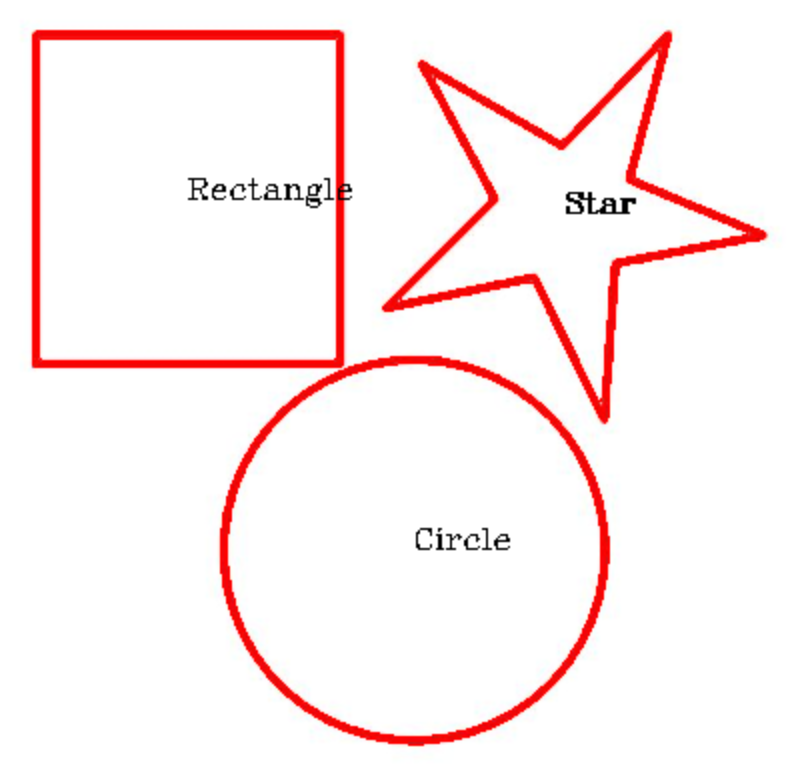


Shapes detected:
Triangle: 0
Square: 0
Rhombus: 0
Parallelogram: 0
Kite: 0
Trapezoid: 0
Rectangle: 1
Pentagon: 0
Hexagon: 0
Star: 1
Circle: 1

The given file contains shapes that can be regularized?: 1


In [146]:
def compute_edge_lengths(vertices):
    edges = []
    for i in range(len(vertices)):
        x1, y1 = vertices[i]
        x2, y2 = vertices[(i + 1) % len(vertices)]
        edge_length = np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)
        edges.append(edge_length)
    return edges

def compute_angles(vertices):
    angles = []
    for i in range(len(vertices)):
        x1, y1 = vertices[i]
        x2, y2 = vertices[(i + 1) % len(vertices)]
        x3, y3 = vertices[(i + 2) % len(vertices)]
        angle = np.arccos(((x2 - x1) * (x3 - x2) + (y2 - y1) * (y3 - y2)) /
                          (np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2) *
                           np.sqrt((x3 - x2) ** 2 + (y3 - y2) ** 2)))
        angles.append(np.degrees(angle))
    return angles

def identify_shape(vertices):
    vertex_count = len(vertices)
    if vertex_count == 3:
        return "Triangle"

    elif vertex_count == 4:
        coords = [tuple(pt[0]) for pt in vertices]
        side_lengths = compute_edge_lengths(coords)
        vertex_angles = compute_angles(coords)

        # Detect Square
        if np.allclose(side_lengths, side_lengths[0]) and \
           np.allclose(vertex_angles, 90):
            return "Square"

        # Detect Rhombus
        if np.allclose(side_lengths, side_lengths[0]) and \
           not np.allclose(vertex_angles, 90):
            return "Rhombus"

        # Detect Parallelogram
        if np.allclose(side_lengths[0], side_lengths[2]) and \
           np.allclose(side_lengths[1], side_lengths[3]) and \
           (np.allclose(vertex_angles[0], vertex_angles[2]) and np.allclose(vertex_angles[1], vertex_angles[3]) or \
            np.allclose(vertex_angles[0], 180 - vertex_angles[2]) and np.allclose(vertex_angles[1], 180 - vertex_angles[3])):
            return "Parallelogram"

        # Detect Kite
        if np.allclose(side_lengths[0], side_lengths[1]) and \
           np.allclose(side_lengths[2], side_lengths[3]):
            return "Kite"

        # Detect Trapezoid
        if np.any(np.isclose(side_lengths[0], side_lengths[2])) or \
           np.any(np.isclose(side_lengths[1], side_lengths[3])):
            return "Trapezoid"

        return "Rectangle"  # Default for other quadrilaterals

    elif vertex_count == 5:
        return "Pentagon"

    elif vertex_count == 6:
        return "Hexagon"

    elif vertex_count == 10 or vertex_count == 12:
        return "Star"

    elif vertex_count > 15:
        return "Circle"

    return "Circle"

def finalize_shape(image, shape_contour):
    # Approximate the contour to a polygon
    delta = 0.02 * cv2.arcLength(shape_contour, True)
    polygon_approx = cv2.approxPolyDP(shape_contour, delta, True)

    num_sides = len(polygon_approx)
    if num_sides == 4:
        vertex_coords = [tuple(pt[0]) for pt in polygon_approx]
        side_lengths = compute_edge_lengths(vertex_coords)
        angles = compute_angles(vertex_coords)

        # Complete a quarter circle to form a full circle if needed
        if num_sides == 4 and (abs(angles[0] - 90) < 5 or abs(angles[1] - 90) < 5):
            # Example logic for completing incomplete shapes
            rect_x, rect_y, rect_w, rect_h = cv2.boundingRect(shape_contour)
            center_coords = (rect_x + rect_w // 2, rect_y + rect_h // 2)
            radius = max(rect_w, rect_h) // 2
            start_deg = 0
            end_deg = 360
            cv2.ellipse(image, center_coords, (radius, radius), 0, start_deg, end_deg, (0, 0, 0), 1)

def identify_shape_and_output(input_img_path):
    # Load image and convert to grayscale
    img = cv2.imread(input_img_path)
    new_width = 400
    aspect_ratio = new_width / img.shape[1]
    new_height = int(img.shape[0] * aspect_ratio)
    resized_image = cv2.resize(img, (new_width, new_height))

    # Duplicate image for symmetries
    duplicate = resized_image.copy()

    gray = cv2.cvtColor(resized_image, cv2.COLOR_BGR2GRAY)

    # Reduce noise by applying Gaussian blur
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    # Apply binary thresholding
    _, threshold = cv2.threshold(blurred, 127, 255, cv2.THRESH_BINARY)

    # Find contours
    contours, _ = cv2.findContours(threshold, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    shapes = []
    shapesMap = {"Triangle": set(), "Square": set(), "Rhombus": set(), "Parallelogram": set(), "Kite": set(), "Trapezoid": set(), \
                "Rectangle": set(), "Pentagon": set(), "Hexagon": set(), "Star": set(), "Circle": set()}

    # Process each contour
    for shape_contour in contours:
        delta = 0.02 * cv2.arcLength(shape_contour, True)

        if delta > 30:
            continue

        polygon_approx = cv2.approxPolyDP(shape_contour, delta, True)

        moments = cv2.moments(shape_contour)
        if moments["m00"] != 0:
            centre_x = int(moments["m10"] / moments["m00"])
            centre_y = int(moments["m01"] / moments["m00"])
        else:
            centre_x, centre_y = 0, 0

        shape_type = identify_shape(polygon_approx)
        cv2.putText(resized_image, shape_type, (centre_x, centre_y), cv2.FONT_HERSHEY_COMPLEX, 0.5, (0, 0, 0), 1)

        cv2.drawContours(resized_image, [shape_contour], -1, (0, 0, 255), 1)

        # Draw symmetry lines based on shape type
        # render_symmetry_lines(resized_image, shape_type, polygon_approx)

        # Update shapes detected
        for i in shapesMap[shape_type]:
            if abs(centre_x - i[0]) <= 3 or abs(centre_y - i[1]) <= 3:
                break
        else:
            shapes.append((shape_type, polygon_approx))
            shapesMap[shape_type].add((int(centre_x), int(centre_y)))

        # Finalize shapes if necessary
        # finalize_shape(resized_image, shape_contour)

    # Scale up the image for visualization
    scaling_factor = 2
    enlarged_image = cv2.resize(resized_image, None, fx=scaling_factor, fy=scaling_factor, interpolation=cv2.INTER_LINEAR)

    # Display the resulting image using cv2_imshow
    cv2_imshow(enlarged_image)

    print("\nShapes detected:")
    for shape, points in shapesMap.items():
        print(f"{shape}: {len(points)}")

    output = 1 if sum(len(i) for i in shapesMap.values()) > 0 else 0

    print(f"\nThe given file contains shapes that can be regularized?: {output}")

    return shapes, duplicate

shapes, duplicate = identify_shape_and_output(input_img_path)

## **Problem 2**
### **Exploring Symmetry in Curves**
Identify symmetries within detected regular shapes and output the lines of symmetries using OpenCV library

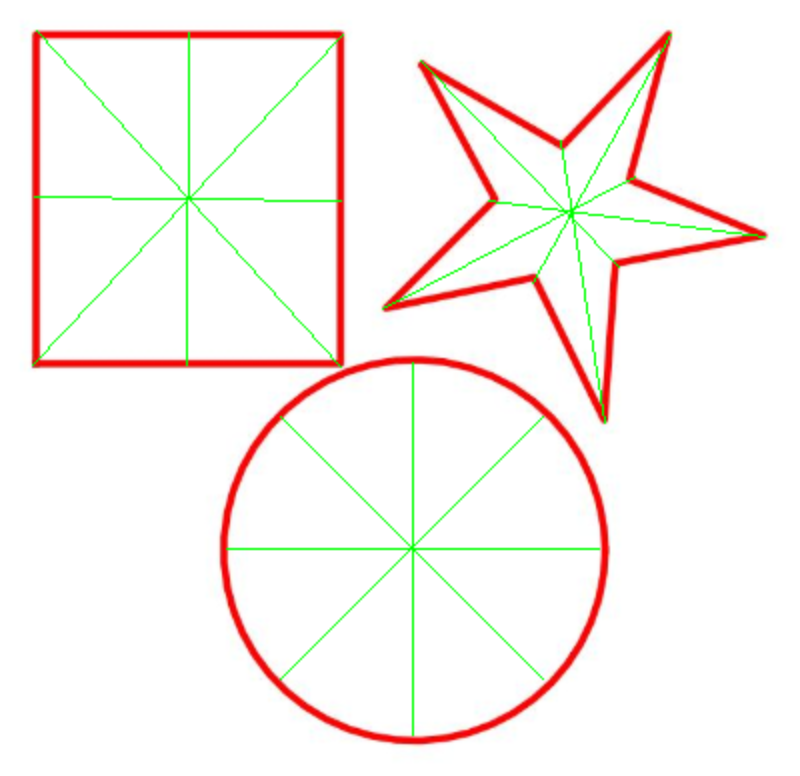


Symmetries detected:
Circle: 4
Star: 5
Rectangle: 4

The given file contains shapes that can be regularized?: 1


In [147]:
def render_symmetry_lines(image, shape_type, vertices):
    if shape_type == "Rectangle" or shape_type == "Square":
        # Unpack the vertices
        top_left, top_right, bottom_right, bottom_left = vertices.reshape(4, 2)

        # Draw vertical and horizontal symmetry lines
        cv2.line(image, ((top_left[0] + bottom_left[0]) // 2, (top_left[1] + bottom_left[1]) // 2),
                  ((top_right[0] + bottom_right[0]) // 2, (top_right[1] + bottom_right[1]) // 2), (0, 255, 0), 1)
        cv2.line(image, ((top_left[0] + top_right[0]) // 2, (top_left[1] + top_right[1]) // 2),
                  ((bottom_left[0] + bottom_right[0]) // 2, (bottom_left[1] + bottom_right[1]) // 2), (0, 255, 0), 1)

        # Draw diagonal symmetry lines
        cv2.line(image, (top_left[0], top_left[1]), (bottom_right[0], bottom_right[1]), (0, 255, 0), 1)
        cv2.line(image, (top_right[0], top_right[1]), (bottom_left[0], bottom_left[1]), (0, 255, 0), 1)

        return 4

    elif shape_type == "Triangle":
        coords = [tuple(pt[0]) for pt in vertices]
        if len(coords) == 3:
            for i in range(3):
                x1, y1 = coords[i]
                x2, y2 = coords[(i + 1) % 3]
                # Calculate midpoint of the opposite side
                mid_x, mid_y = (coords[(i + 2) % 3][0] + coords[(i + 1) % 3][0]) // 2, (coords[(i + 2) % 3][1] + coords[(i + 1) % 3][1]) // 2
                # Draw median
                cv2.line(image, (x1, y1), (mid_x, mid_y), (0, 255, 0), 1)

            return 3

    elif shape_type == "Circle":
        moments = cv2.moments(vertices)
        if moments["m00"] != 0:
            cx = int(moments["m10"] / moments["m00"])
            cy = int(moments["m01"] / moments["m00"])
            # Draw vertical and horizontal symmetry lines through the center
            height, width = image.shape[:2]

            # Calculate the radius (distance from center to any point on the circle boundary)
            radius = int(cv2.pointPolygonTest(vertices, (cx, cy), True)) + 5

            # Horizontal and vertical lines
            cv2.line(image, (cx - radius, cy), (cx + radius, cy), (0, 255, 0), 1)
            cv2.line(image, (cx, cy + radius), (cx, cy - radius), (0, 255, 0), 1)

            # Relative coordinates of centres of quareter arcs from horizontal line of symmetry
            # Based on trigonometry
            x = radius / (2 + two_root)
            y = x * (two_root + 1)

            # Draw diagonal symmetry lines
            # Top-left to bottom-right diagonal
            cv2.line(image, (int(cx - radius + x), int(cy + y)), (int(cx + radius - x), int(cy - y)), (0, 255, 0), 1)

            # Top-right to bottom-left diagonal
            cv2.line(image, (int(cx - radius + x), int(cy - y)), (int(cx + radius - x), int(cy + y)), (0, 255, 0), 1)

            return 4

    elif shape_type == "Star":
        coords = [tuple(pt[0]) for pt in vertices]

        if len(coords) == 10:
            moments = cv2.moments(vertices)
            if moments["m00"] != 0:
                # Find centre of star
                cx = int(moments["m10"] / moments["m00"])
                cy = int(moments["m01"] / moments["m00"])

                # Draw symmetry lines
                for i in range(len(coords) // 2):
                    x1, y1 = coords[i]
                    x2, y2 = coords[(i + len(coords) // 2) % len(coords)]  # Opposite vertex in the star
                    cv2.line(image, (x1, y1), (x2, y2), (0, 255, 0), 1)

                return len(coords) // 2

    elif shape_type == "Kite" or shape_type == "Rhombus":
        coords = [tuple(pt[0]) for pt in vertices]
        if len(coords) == 4:
            # Draw diagonals
            diag1 = np.linalg.norm(np.array(coords[0]) - np.array(coords[2]))
            diag2 = np.linalg.norm(np.array(coords[1]) - np.array(coords[3]))
            moments = cv2.moments(vertices)
            if moments["m00"] != 0:
                cx = int(moments["m10"] / moments["m00"])
                cy = int(moments["m01"] / moments["m00"])
                cv2.line(image, coords[0], coords[2], (0, 255, 0), 1)  # Diagonal 1
                cv2.line(image, coords[1], coords[3], (0, 255, 0), 1)  # Diagonal 2

            return 2

    elif shape_type == "Parallelogram":
        coords = [tuple(pt[0]) for pt in vertices]
        if len(coords) == 4:
            # Draw diagonals of the parallelogram
            cv2.line(image, coords[0], coords[2], (0, 255, 0), 1)
            cv2.line(image, coords[1], coords[3], (0, 255, 0), 1)

            return 2

    elif shape_type == "Trapezoid":
        coords = [tuple(pt[0]) for pt in vertices]
        if len(coords) == 4:
            # Draw symmetry line (average of two non-parallel sides)
            x1, y1 = coords[0]
            x2, y2 = coords[1]
            x3, y3 = coords[2]
            x4, y4 = coords[3]
            midpoint1 = ((x1 + x2) / 2, (y1 + y2) / 2)
            midpoint2 = ((x3 + x4) / 2, (y3 + y4) / 2)
            cv2.line(image, (int(midpoint1[0]), int(midpoint1[1])), (int(midpoint2[0]), int(midpoint2[1])), (0, 255, 0), 1)

            return 1

    return 0

symmetries = []

# Process each contour
for shape_type, polygon in shapes:
    # Draw symmetry lines based on shape type
    num = render_symmetry_lines(duplicate, shape_type, polygon)

    symmetries.append((shape_type, num))

    # Finalize shapes if necessary
    # finalize_shape(resized_image, shape_contour)

# Scale up the image for visualization
scaling_factor = 2
enlarged_image = cv2.resize(duplicate, None, fx=scaling_factor, fy=scaling_factor, interpolation=cv2.INTER_LINEAR)

# Display the resulting image using cv2_imshow
cv2_imshow(enlarged_image)

print("\nSymmetries detected:")
for shape, num in symmetries:
    print(f"{shape}: {num}")

output = 1 if sum(i[1] for i in symmetries) > 0 else 0

print(f"\nThe given file contains shapes that can be regularized?: {output}")